In [326]:
import os
import numpy as np
import scipy.io.wavfile
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt

In [327]:
def process_mfcc_5days(file_path, sample_rate=1258, return_as='df'):
    # 讀取音頻檔案
    signal = scipy.io.wavfile.read(file_path)[1]
    frame_size = 0.008
    frame_stride = 0.008

    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate

    # 信號的總長度，將幀長度和步長四捨五入到最接近的整數，並計算總幀數
    signal_length = len(signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)+1)
    print(signal_length)
    print(frame_length)
    print(frame_step)
    print(num_frames)

    # 確保音頻信號的長度足以被完全切割成幀。如果信號太短，它將用零填充到適當的長度。
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z)
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]
    
    # 每個幀都乘以了漢明窗，減少幀的邊緣處的信號不連續性
    frames *= np.hamming(frame_length)
  
    NFFT = 512

    # 執行 FFT 轉換並計算幅度
    mag_frames = np.absolute(np.fft.rfft(frames, NFFT))

    # 計算頻率軸的值
    freqs = np.fft.rfftfreq(NFFT, 1.0 / sample_rate)
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))

    # 計算對數能量
    log_energy = np.log(np.sum(pow_frames, axis=1))

    # 設定梅爾濾波器組參數
    n_filters = 22  # 梅爾濾波器的數量
    low_freq_mel = 0  # 最低的梅爾頻率
    high_freq_mel = (2595 * np.log10(1 + (sample_rate/2) / 700))  # 最高的梅爾頻率

    # 計算梅爾點
    mel_points = np.linspace(low_freq_mel, high_freq_mel, n_filters + 2)  # 等間隔的梅爾頻率
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # 將梅爾頻率轉換回赫茲頻率

    # 計算濾波器邊界在FFT窗中的位置
    bin = np.floor((NFFT + 1) * hz_points / sample_rate)

    # 創建濾波器組
    fbank = np.zeros((n_filters, int(np.floor(NFFT / 2 + 1))))
    for m in range(1, n_filters + 1):
        f_m_minus = int(bin[m - 1])   # 左邊界
        f_m = int(bin[m])             # 中心點
        f_m_plus = int(bin[m + 1])    # 右邊界

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    # 應用濾波器組到功率谱上
    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)
   
    # 計算對數濾波器銀行能量
    filter_banks = np.log(filter_banks)

    # 離散餘弦變換以得到MFCC
    num_ceps = 12
    mfccs = scipy.fftpack.dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1: num_ceps+1]

    # 計算MFCC的一階和二階差分
    # delta_mfccs = np.diff(mfccs, n=1, axis=0)
    # delta_mfccs = np.vstack([np.zeros(delta_mfccs.shape[1]), delta_mfccs])  
    # delta2_mfccs = np.diff(delta_mfccs, n=1, axis=0)
    # delta2_mfccs = np.vstack([np.zeros(delta2_mfccs.shape[1]), delta2_mfccs])  # 首行補零
    
    # 將原始的MFCC特徵、一階差分和二階差分合併
    mfccs_features = np.hstack([mfccs, log_energy.reshape(-1, 1)])
    # mfccs_features = np.hstack([mfccs, delta_mfccs])


    # # 進行特徵歸一化
    # mfccs_features -= np.mean(mfccs_features, axis=0)

    # # 初始化MinMaxScaler並將特徵縮放到0到1之間
    # scaler = MinMaxScaler(feature_range=(0, 1))
    # mfccs_scaled = scaler.fit_transform(mfccs_features)

    # 創建 MFCC DataFrame
    # mfccs_df = pd.DataFrame(mfccs, columns=[f"MFCC{i+1}" for i in range(mfccs.shape[1])])
    
    num_mfcc_features = 13
    mfccs_df = pd.DataFrame(mfccs_features, columns=[f"MFCC_{i+1}" for i in range(num_mfcc_features)] )
    # mfccs_df = pd.DataFrame(mfccs_features, columns=[f"MFCC_{i+1}" for i in range(num_mfcc_features)] + 
                                                #    [f"Delta_{i+1}" for i in range(num_mfcc_features)] )


    print(mfccs_features.shape)
    print("MFCCs scaled max:", np.max(mfccs_features))
    print("MFCCs scaled min:", np.min(mfccs_features))

    return mfccs_df

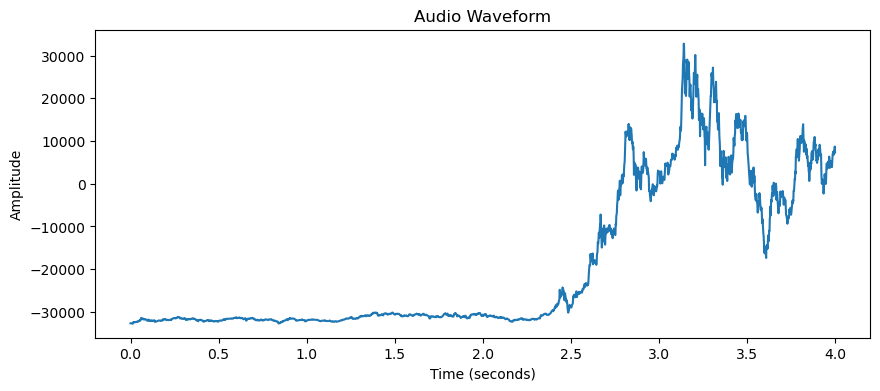

In [328]:
def plot_audio_waveform(file_path):
    # 讀取音頻檔案
    sample_rate, signal = scipy.io.wavfile.read(file_path)

    # 計算時間軸數據
    time_axis = np.linspace(0, len(signal) / sample_rate, num=len(signal))

    # 繪製波形圖
    plt.figure(figsize=(10, 4))
    plt.plot(time_axis, signal)
    plt.title("Audio Waveform")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.show()

# 指定要繪製波形圖的音頻檔案路徑
file_path = "tslaopen_stockPriceAudio.wav"
plot_audio_waveform(file_path)

收盤價

In [329]:
# 讀取音頻檔案並提取 MFCC 特徵
close_mfcc_df5 = process_mfcc_5days("tsla_stockPriceAudio.wav")

# 將 DataFrame 轉換為 NumPy 數組
close_mfcc_df5 = close_mfcc_df5.to_numpy()

# 顯示 MFCC 特徵數組
print(close_mfcc_df5)

5032
10
10
504
(504, 13)
MFCCs scaled max: 21.38470822845552
MFCCs scaled min: -5.6193997645768
[[ 1.59974654e+01  4.78205099e+00 -3.10896102e+00 ...  8.33787981e-01
  -2.63497830e-01  2.13847082e+01]
 [ 1.60475267e+01  4.75235574e+00 -3.18196109e+00 ...  9.09402786e-01
  -3.00784701e-01  2.13845886e+01]
 [ 1.59737555e+01  4.80250782e+00 -3.08180931e+00 ...  7.96525066e-01
  -2.51295806e-01  2.13658507e+01]
 ...
 [ 1.46987128e+01  4.09999692e+00 -7.39168779e-01 ... -1.32629429e-01
  -8.02575610e-01  1.83486161e+01]
 [ 1.55306482e+01  4.44325505e+00 -2.86046001e+00 ...  5.36863157e-01
  -3.79653584e-01  1.84686984e+01]
 [ 1.83620667e+00 -9.15124863e-01  2.38671680e-01 ... -2.01711374e-02
   2.48621608e-02  1.36722267e+01]]


開盤價

In [330]:
# # 讀取音頻檔案並提取 MFCC 特徵
# open_mfcc_df = process_mfcc("tslaopen_stockPriceAudio.wav")

# # 將 DataFrame 轉換為 NumPy 數組
# open_mfcc_features = open_mfcc_df.to_numpy()

# # 顯示 MFCC 特徵數組
# print(open_mfcc_features)

最高點

In [331]:
# # 讀取音頻檔案並提取 MFCC 特徵
# high_mfcc_df = process_mfcc("tslahigh_stockPriceAudio.wav")

# # 將 DataFrame 轉換為 NumPy 數組
# high_mfcc_features = high_mfcc_df.to_numpy()

# # 顯示 MFCC 特徵數組
# print(high_mfcc_features)

最低點

In [332]:
# # 讀取音頻檔案並提取 MFCC 特徵
# low_mfcc_df = process_mfcc("tslalow_stockPriceAudio.wav")

# # 將 DataFrame 轉換為 NumPy 數組
# low_mfcc_features = low_mfcc_df.to_numpy()

# # 顯示 MFCC 特徵數組
# print(low_mfcc_features)

成交量

In [333]:
# 讀取音頻檔案並提取 MFCC 特徵
volume_mfcc_df = process_mfcc_5days("tslavolume_stockPriceAudio.wav")

# 將 DataFrame 轉換為 NumPy 數組
volume_mfcc_features = volume_mfcc_df.to_numpy()

# 顯示 MFCC 特徵數組
print(volume_mfcc_features)

5032
10
10
504
(504, 13)
MFCCs scaled max: 21.32422587729246
MFCCs scaled min: -6.5021375095316145
[[15.49629741  4.44721523 -2.22056343 ...  0.20339055 -0.22646758
  21.05962841]
 [ 9.05397815 -0.97443496  0.80646642 ...  0.18600283 -0.13991816
  20.40337476]
 [14.65854502  3.14263463 -0.36992406 ...  0.08453971 -0.51435417
  20.75132087]
 ...
 [15.9240172   4.42417327 -3.09651878 ...  0.86248669 -0.28301831
  20.79734381]
 [16.21382898  3.95674785 -3.12861079 ...  1.01556773 -0.48960175
  20.9757882 ]
 [ 1.65199048 -0.81878165  0.18651599 ... -0.02148891  0.0258794
  16.46088427]]


In [334]:
mfcc_features = np.concatenate(
    (close_mfcc_df5, volume_mfcc_features),
    axis=1
)


mfcc_features.shape

(504, 26)

頻譜圖數據

In [335]:
import python_speech_features as psf

def calculate_magnitude_spectrum_5days(file_path, sample_rate=1258, frame_size=0.008, frame_stride=0.008, NFFT=13):
    # 讀取音頻檔案
    signal = scipy.io.wavfile.read(file_path)[1]

    # 計算幀長和步長
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    signal_length = len(signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step)+1)

    # 確保音頻信號的長度足以被完全切割成幀
    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(signal, z)
    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # 每個幀都乘以了漢明窗
    frames *= np.hamming(frame_length)
  
    # 執行 FFT 轉換並計算幅度譜
    mag_frames = psf.sigproc.magspec(frames, NFFT)

    return mag_frames

In [336]:
close_file_path = 'tsla_stockPriceAudio.wav'
close_magnitude_spectrum_5days = calculate_magnitude_spectrum_5days(close_file_path)
print(close_magnitude_spectrum_5days.shape)

(504, 7)


In [337]:
volume_file_path = 'tslavolume_stockPriceAudio.wav'
volume_magnitude_spectrum_5days = calculate_magnitude_spectrum_5days(volume_file_path)
print(volume_magnitude_spectrum_5days.shape)

(504, 7)


In [338]:
close_mfcc_df5_with_magnitude = np.concatenate([mfcc_features, close_magnitude_spectrum_5days, volume_magnitude_spectrum_5days], axis=-1)

In [339]:
print(close_mfcc_df5_with_magnitude.shape)

(504, 40)


加入真實值

In [340]:
# 讀取CSV文件
df = pd.read_csv('Tesla_Close_Prices_2023.csv', parse_dates=['Date'])

# 確保數據按日期排序
df.sort_values('Date', inplace=True)

# 使用所有的股價數據
prices_every_day = df.iloc[4:, :]['Close'].values  # 從第五天開始取所有數據

# 檢查 MFCC 特徵數組和股價數據的長度
mfcc_features_df5_length = min(len(prices_every_day), close_mfcc_df5_with_magnitude.shape[0])
mfcc_features_df5 = close_mfcc_df5_with_magnitude[:mfcc_features_df5_length, :]
prices_every_day = prices_every_day[:mfcc_features_df5_length]

# 檢查現在的數據長度
if prices_every_day.shape[0] != mfcc_features_df5.shape[0]:
    raise ValueError("提取的股價數據與調整後的 MFCC 幀數仍不匹配。")

# 將股價數據添加到 MFCC 特徵數組中
mfcc_with_prices_df5 = np.hstack((mfcc_features_df5, prices_every_day.reshape(-1, 1)))

print("MFCC with Stock Prices for every day from day 5:")
print(mfcc_with_prices_df5.shape)

MFCC with Stock Prices for every day from day 5:
(504, 41)


reshape_20_days

In [341]:
# # 假設 mfcc_with_prices_df5 是您的原始數據集 (503, 21)
# data = np.array(mfcc_with_prices_df5)

# # 計算新的數據集中的樣本數
# num_samples = (data.shape[0] - 4 + 1)  # 從數據集的最後一個frame往前計算

# # 創建一個新的數據集來存儲20天的數據
# mfcc_with_prices_df20 = np.zeros((num_samples, 4, 41))  # 初始化數組

# for i in range(num_samples):
#     mfcc_with_prices_df20[i] = data[i:i+4]  # 擷取連續的4個frame

# # twenty_day_dataset 的形狀將是 (num_samples, 4, 21)，其中 num_samples 是計算得出的樣本數
# print("MFCC with Stock Prices 20days:", mfcc_with_prices_df20.shape)

reshape_60_days

In [342]:
# # 計算新的數據集中的樣本數
# num_samples = (data.shape[0] - 12 + 1)  # 從數據集的最後一個frame往前計算

# # 創建一個新的數據集來存儲60天的數據
# mfcc_with_prices_df60 = np.zeros((num_samples, 12, 41))  # 初始化數組

# for i in range(num_samples):
#     mfcc_with_prices_df60[i] = data[i:i+12]  # 擷取連續的12個frame

# # sixty_day_dataset 的形狀將是 (num_samples, 12, 21)，其中 num_samples 是計算得出的樣本數
# print("MFCC with Stock Prices 60days:", mfcc_with_prices_df60.shape)

In [343]:
# # 假設 five_day_dataset 是五天的數據集，twenty_day_dataset 是二十天的數據集
# five_day_dataset = np.array(mfcc_with_prices_df5)
# twenty_day_dataset = np.array(mfcc_with_prices_df20)  # 這需要您已經有一個名為 twenty_day_dataset 的變數

# # 調整五天的數據集
# adjusted_five_day_dataset = five_day_dataset[11:]  # 刪除前11個樣本

# # 調整二十天的數據集
# adjusted_twenty_day_dataset = twenty_day_dataset[8:]  # 刪除前8個樣本

# print("5days:", adjusted_five_day_dataset.shape)
# print("20days:", adjusted_twenty_day_dataset.shape)
# print("60days:",mfcc_with_prices_df60.shape)

標記label

In [344]:
# 讀取CSV檔案
df = pd.read_csv('Tesla_Close_Prices_2023.csv')


In [345]:
# 設定價格變動的閾值
threshold = 0.01

# 初始化標籤列表
labels = ['0']  # 將第一天標記為持平

# 使用 for 迴圈遍歷股價數據，從第二個交易日開始
for i in range(1, len(df)):
    # 計算前一天和當天的股價變化百分比
    price_change = (df['Close'].iloc[i] - df['Close'].iloc[i - 1]) / df['Close'].iloc[i - 1]
    
    # 判斷價格變動並分配標籤
    if price_change > threshold:
        labels.append('1')  # 上漲
    elif price_change < -threshold:
        labels.append('-1')  # 下跌
    else:
        labels.append('0')  # 持平

# 將標籤列表添加到原始數據的副本中
data_with_labels = df.copy()
data_with_labels['Label'] = labels

# 將標籤轉換為獨熱編碼
labels_one_hot = pd.get_dummies(data_with_labels['Label'])

# 將布林型態的獨熱編碼轉換為整數型態
labels_one_hot = labels_one_hot.astype(int)

# 將獨熱編碼的標籤添加回原數據集
data_with_labels_one_hot = pd.concat([data_with_labels, labels_one_hot], axis=1)

# 顯示帶有獨熱編碼標籤的 DataFrame 頭部數據
print(data_with_labels_one_hot.head(10))


         Date      Close Label  -1  0  1
0  2014-01-02  10.006667     0   0  1  0
1  2014-01-03   9.970667     0   0  1  0
2  2014-01-06   9.800000    -1   1  0  0
3  2014-01-07   9.957333     1   0  0  1
4  2014-01-08  10.085333     1   0  0  1
5  2014-01-09   9.835333    -1   1  0  0
6  2014-01-10   9.714667    -1   1  0  0
7  2014-01-13   9.289333    -1   1  0  0
8  2014-01-14  10.751333     1   0  0  1
9  2014-01-15  10.942000     1   0  0  1


In [346]:
len(data_with_labels_one_hot)

2516

In [347]:
labels_every_day = data_with_labels_one_hot.iloc[:]
adjusted_labels = labels_every_day.iloc[4:4 + mfcc_with_prices_df5.shape[0]]

# 打印調整後的標籤數據集和特徵數據集的形狀以檢查對齊
print("Adjusted labels shape:", adjusted_labels.shape)
print("Adjusted five_day_dataset shape:", mfcc_with_prices_df5.shape)

# 檢查調整後的標籤數量是否與調整後的特徵數據集行數匹配
if adjusted_labels.shape[0] != mfcc_with_prices_df5.shape[0]:
    raise ValueError("調整後的標籤數量與特徵數據的行數不匹配，請檢查對齊情況。")

# 標籤獨熱編碼列名
label_columns = ['-1', '0', '1']  # 根據您的具體列名進行調整

# 提取調整後的獨熱編碼的標籤部分
adjusted_label_values = adjusted_labels[label_columns].values

# 檢查數據，可選操作
print("調整後的特徵數據形狀:", mfcc_with_prices_df5.shape)
print("調整後的標籤數據形狀:", adjusted_label_values.shape)

Adjusted labels shape: (504, 6)
Adjusted five_day_dataset shape: (504, 41)
調整後的特徵數據形狀: (504, 41)
調整後的標籤數據形狀: (504, 3)


In [348]:
a5 =  mfcc_with_prices_df5
# a20 = adjusted_twenty_day_dataset
# a60 = mfcc_with_prices_df60

b = adjusted_label_values

print(a5.shape, b.shape)

(504, 41) (504, 3)


模型訓練

In [349]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

In [364]:
# 整合特徵數據和標籤數據
X = mfcc_with_prices_df5
y = adjusted_label_values

# 將多分類標籤轉換回一維形式
y = np.argmax(y, axis=1)

# 分割數據集為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)


In [365]:
print("訓練集樣本數：", len(y_train))
print("測試集樣本數：", len(y_test))
print("總樣本數：", len(y_train) + len(y_test))


訓練集樣本數： 403
測試集樣本數： 101
總樣本數： 504


In [366]:
# 計算每個類別的比例
def calculate_class_distribution(y):
    unique, counts = np.unique(y, return_counts=True)
    distribution = dict(zip(unique, counts))
    total = len(y)
    for key in distribution:
        distribution[key] = distribution[key] / total
    return distribution

train_distribution = calculate_class_distribution(y_train)
test_distribution = calculate_class_distribution(y_test)

print("Train set class distribution:")
for label, proportion in train_distribution.items():
    print(f'Class {label}: {proportion:.2%}')

print("Test set class distribution:")
for label, proportion in test_distribution.items():
    print(f'Class {label}: {proportion:.2%}')

Train set class distribution:
Class 0: 31.02%
Class 1: 37.47%
Class 2: 31.51%
Test set class distribution:
Class 0: 23.76%
Class 1: 37.62%
Class 2: 38.61%


In [367]:
# 特徵縮放
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 設定連續超參數範圍
param_dist = {
    'C': np.logspace(-2, 2, 100),  # 0.1 到 100 的對數連續範圍
    'gamma': np.logspace(-3, 0, 100),  # 0.001 到 1 的對數連續範圍
    'kernel': ['poly', 'rbf'],
    'degree': [3,4,5]  # 固定 degree 為 3，因為你使用的是三次多項式核
}

In [368]:
# 創建SVM模型
svm_model = SVC()

# 創建RandomizedSearchCV對象（不使用交叉驗證）
random_search = RandomizedSearchCV(svm_model, param_distributions=param_dist, n_iter=500, refit=True, verbose=2, cv=5, random_state=42)

# 訓練模型
random_search.fit(X_train, y_train)

# 輸出最佳參數
print(f"最佳參數: {random_search.best_params_}")

Fitting 5 folds for each of 500 candidates, totalling 2500 fits
[CV] END C=62.802914418342596, degree=3, gamma=0.0021544346900318843, kernel=poly; total time=   0.0s
[CV] END C=62.802914418342596, degree=3, gamma=0.0021544346900318843, kernel=poly; total time=   0.0s
[CV] END C=62.802914418342596, degree=3, gamma=0.0021544346900318843, kernel=poly; total time=   0.0s
[CV] END C=62.802914418342596, degree=3, gamma=0.0021544346900318843, kernel=poly; total time=   0.0s
[CV] END C=62.802914418342596, degree=3, gamma=0.0021544346900318843, kernel=poly; total time=   0.0s
[CV] END C=0.11233240329780277, degree=3, gamma=0.8697490026177834, kernel=rbf; total time=   0.0s
[CV] END C=0.11233240329780277, degree=3, gamma=0.8697490026177834, kernel=rbf; total time=   0.0s
[CV] END C=0.11233240329780277, degree=3, gamma=0.8697490026177834, kernel=rbf; total time=   0.0s
[CV] END C=0.11233240329780277, degree=3, gamma=0.8697490026177834, kernel=rbf; total time=   0.0s
[CV] END C=0.11233240329780277

In [369]:
# 使用最佳參數進行預測
best_svm_model = random_search.best_estimator_
y_pred_train = best_svm_model.predict(X_train)
y_pred_test = best_svm_model.predict(X_test)

# 評估模型
accuracy_train = accuracy_score(y_train, y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f'Training Accuracy: {accuracy_train:.4f}')
print(f'Test Accuracy: {accuracy_test:.4f}')
print('Test Classification Report:')
print(classification_report(y_test, y_pred_test, target_names=['Down', 'Same', 'Up']))

Training Accuracy: 0.5385
Test Accuracy: 0.3861
Test Classification Report:
              precision    recall  f1-score   support

        Down       0.38      0.42      0.40        24
        Same       0.37      0.45      0.40        38
          Up       0.41      0.31      0.35        39

    accuracy                           0.39       101
   macro avg       0.39      0.39      0.39       101
weighted avg       0.39      0.39      0.38       101



In [370]:
# # 進行預測
# y_pred_train = svm_model.predict(X_train)
# y_pred_test = svm_model.predict(X_test)

# # 評估模型
# accuracy_train = accuracy_score(y_train, y_pred_train)
# accuracy_test = accuracy_score(y_test, y_pred_test)
# print(f'Training Accuracy: {accuracy_train:.4f}')
# print(f'Test Accuracy: {accuracy_test:.4f}')
# print('Test Classification Report:')
# print(classification_report(y_test, y_pred_test, target_names=['Down', 'Same', 'Up']))


Training Confusion Matrix:
[[54 46 25]
 [26 97 28]
 [26 35 66]]
Test Confusion Matrix:
[[10 10  4]
 [ 8 17 13]
 [ 8 19 12]]


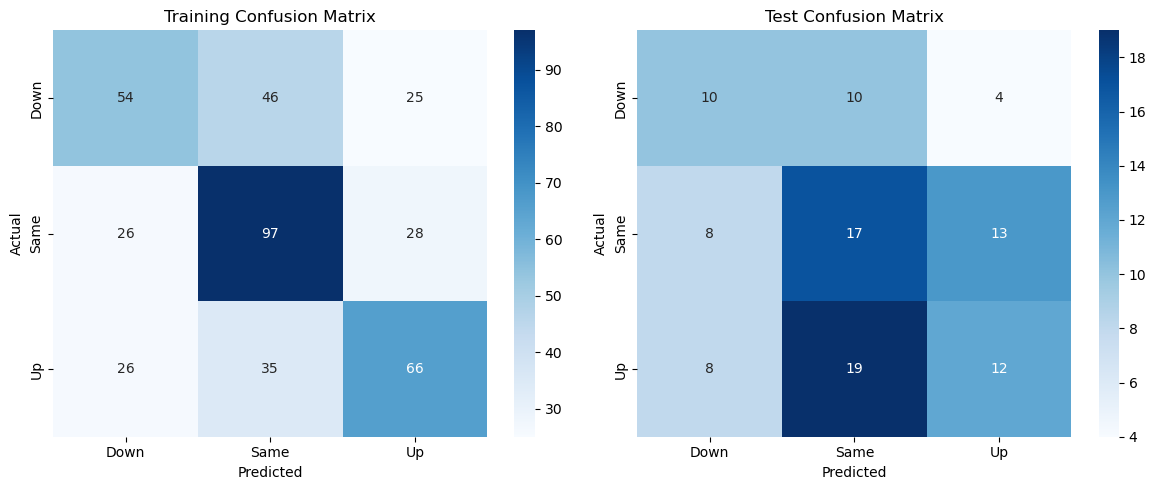

In [371]:
# 計算混淆矩陣
cm_train = confusion_matrix(y_train, y_pred_train)
cm_test = confusion_matrix(y_test, y_pred_test)
print("Training Confusion Matrix:")
print(cm_train)
print("Test Confusion Matrix:")
print(cm_test)

# 繪製混淆矩陣
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Same', 'Up'], yticklabels=['Down', 'Same', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Training Confusion Matrix')

plt.subplot(1, 2, 2)
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=['Down', 'Same', 'Up'], yticklabels=['Down', 'Same', 'Up'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Test Confusion Matrix')

plt.tight_layout()
plt.show()